In [4]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


In [5]:
import json

# Load configuration
with open("../../config/config_notebooks_HER2_with_TNBC_model.json", "r") as config_file:
    config = json.load(config_file)


In [6]:
## Try to plot the bootstrapped ARI patient values

all_dfs = []
opti_clusts = {}
for model_type, names, benchmark_path in zip([config['retrained_model_list2_type']],
                                            [config['retrained_model_list2']],
                                            [config['retrained_benchmark_folder2']]):
    path_to_unsupervised_clustering = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
    optimal_clusters = pd.read_csv(os.path.join(path_to_unsupervised_clustering, "optimal_clusters.csv"), index_col=0)
    
    for name in names:
        opti_clusts[name] = optimal_clusters.loc[name, 'n_clusters']

        # print(f"Processing {name}...")
        filename = f"scores_umap_across_parameters_{optimal_clusters.loc[name, 'n_clusters']}_clusters.json"
        with open(os.path.join(path_to_unsupervised_clustering, name, filename), "r") as f:
            model_summary = json.load(f)
            df_ = []
            for min_dist in [0.001, 0.1]:
                d = pd.DataFrame(model_summary[str(min_dist)])
                d = d.T
                d["min_dist"] = min_dist
                df_.append(d)
            df_ = pd.concat(df_)
        
            df_["model"] = name

            all_dfs.append(df_)

In [7]:
df = pd.concat(all_dfs)
df["batch effect mitigation"] = 1 - df["ARI_patient"]

In [16]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = ['uni',
 'uni_full_koleo_16384_prototypes',
 'TNBC_uni_full_koleo_4096_prototypes']





In [17]:
# make 'model' a categorical with the desired order (append any unseen models at the end),
# then sort the dataframe by that categorical order
desired = list(sorted_retrained_models)
present_in_desired = [m for m in desired if m in df['model'].unique()]
others = [m for m in df['model'].unique() if m not in present_in_desired]
new_order = present_in_desired + others

df['model'] = pd.Categorical(df['model'], categories=new_order, ordered=True)
df = df.sort_values('model').reset_index(drop=True)

# quick check
print(df['model'].cat.categories)

Index(['uni', 'uni_full_koleo_16384_prototypes',
       'TNBC_uni_full_koleo_4096_prototypes'],
      dtype='object')


In [18]:
new_order

['uni',
 'uni_full_koleo_16384_prototypes',
 'TNBC_uni_full_koleo_4096_prototypes']

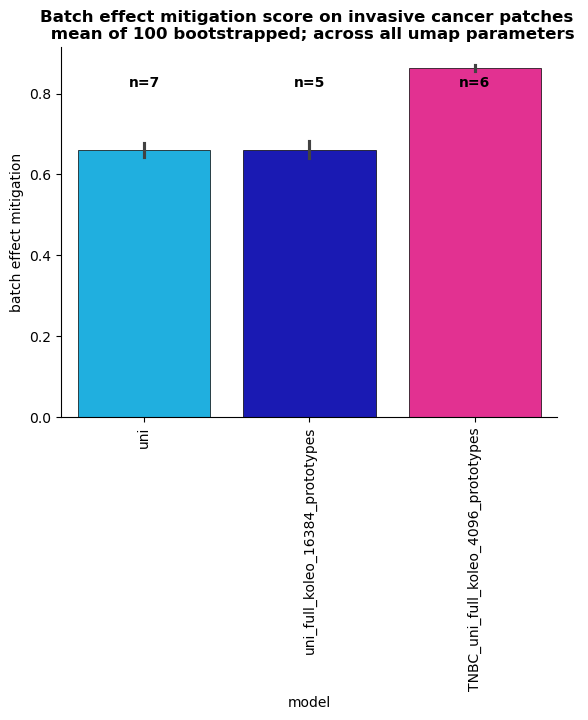

In [19]:
sns.barplot(data=df, x="model", y="batch effect mitigation", linewidth=0.5,
            edgecolor="black", palette=config["retrained_color_palette"], order=new_order)
sns.despine()
plt.xticks(rotation=90);
plt.title(f"Batch effect mitigation score on invasive cancer patches \n mean of 100 bootstrapped; across all umap parameters",
           weight='bold')

for i, n in opti_clusts.items():
    plt.text(x=i, y=0.81, s=f"n={n}", ha='center', va='bottom', weight='bold')